# HRC Price Prediction for Japan

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [ ]:
# Read processed csv
df_CN = pd.read_csv('../data/processed/after_fillna.csv')
df_CN = df_CN[['Date', 'Month', 'HRC (FOB, $/t)']]

In [ ]:
# Read Japan HRC price csv
df_JP = pd.read_excel('../data/raw/Japan HRC FOB.xlsx')
df_JP.rename(columns={'Month': 'Month_JP'}, inplace=True)

In [ ]:
hrc_price_CN_JP = pd.concat([df_CN, df_JP], axis=1, ignore_index=False)
hrc_price_CN_JP

,Date,Month,"HRC (FOB, $/t)",Month_JP,Japan HRC FOB ($/t)
0,2006-01-01,Jan-06,388.0,2006-01-01,480
1,2006-02-01,Feb-06,388.0,2006-02-01,480
2,2006-03-01,Mar-06,449.0,2006-03-01,490
3,2006-04-01,Apr-06,478.0,2006-04-01,460
4,2006-05-01,May-06,505.0,2006-05-01,490
...,...,...,...,...,...
225,2024-10-01,Oct-24,497.0,2024-10-01,540
226,2024-11-01,Nov-24,485.0,2024-11-01,550
227,2024-12-01,Dec-24,473.0,2024-12-01,520
228,2025-01-01,Jan-25,461.0,2025-01-01,520


In [129]:
hrc_price_CN_JP.columns

Index(['Date', 'Month', 'HRC (FOB, $/t)', 'Month_JP', 'Japan HRC FOB ($/t)'], dtype='object')

In [130]:
hrc_price_CN_JP.rename(columns={'HRC (FOB, $/t)': 'China HRC (FOB, $/t)',
                               'Japan HRC FOB ($/t)': 'Japan HRC (FOB, $/t)'}, inplace=True)
hrc_price_CN_JP.drop(['Month_JP'], axis=1, inplace=True)
hrc_price_CN_JP

,Date,Month,"China HRC (FOB, $/t)","Japan HRC (FOB, $/t)"
0,2006-01-01,Jan-06,388.0,480
1,2006-02-01,Feb-06,388.0,480
2,2006-03-01,Mar-06,449.0,490
3,2006-04-01,Apr-06,478.0,460
4,2006-05-01,May-06,505.0,490
...,...,...,...,...
225,2024-10-01,Oct-24,497.0,540
226,2024-11-01,Nov-24,485.0,550
227,2024-12-01,Dec-24,473.0,520
228,2025-01-01,Jan-25,461.0,520


## Scatterplot of Japan and China HRC prices

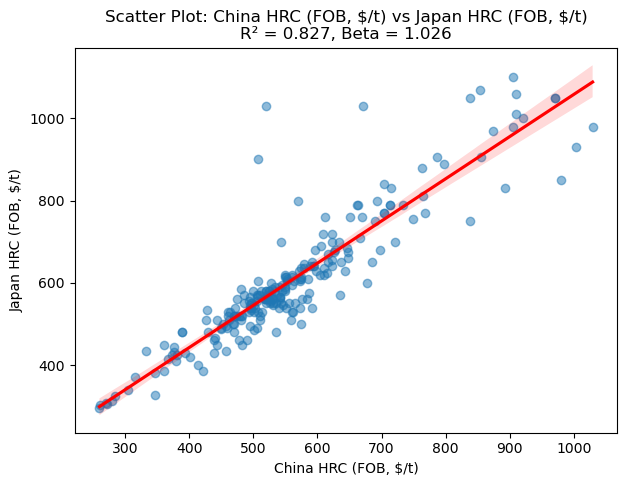

In [131]:
from scipy.stats import linregress

x_col = 'China HRC (FOB, $/t)'
y_col = 'Japan HRC (FOB, $/t)'

# Drop NaN values for the current variable
temp_df = hrc_price_CN_JP[[x_col, y_col]].dropna()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(temp_df[x_col], temp_df[y_col])
r_squared = r_value**2  # R² value

# Create plot
plt.figure(figsize=(7, 5))
sns.regplot(x=temp_df[x_col], y=temp_df[y_col], scatter_kws={"alpha": 0.5}, line_kws={"color": "red"})

# Labels and title
plt.xlabel(x_col)
plt.ylabel(y_col)
x_col_name = x_col.replace("$", r"\$")
y_col_name = y_col.replace("$", r"\$")
plt.title(f"Scatter Plot: {x_col_name} vs {y_col_name}\nR² = {r_squared:.3f}, Beta = {slope:.3f}")

# Show plot
plt.show()

In [132]:
hrc_price_CN_JP.to_csv('../data/processed/hrc_price_CN_JP.csv', index=False)

## Prediction of Japan HRC Prices using China's Prices - Linear Regression

In [133]:
# Prepare X and y columns
X = temp_df[["China HRC (FOB, $/t)"]]
y = temp_df["Japan HRC (FOB, $/t)"]

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
# Model fitting
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [135]:
# Model predictions
y_pred = model.predict(X_test)

In [136]:
# Get feature names and coefficients
feature_names = ["Intercept"] + list(X.columns)
intercept_linear_reg = model.intercept_
coef_linear_reg = model.coef_

coefficients_linear_reg = [intercept_linear_reg] + list(coef_linear_reg)

# Display results
pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients_linear_reg})


,Feature,Coefficient
0,Intercept,20.806508
1,"China HRC (FOB, $/t)",1.049746


In [137]:
# Error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error: ', mae)
print('Mean Squared Error: ', mse)
print('Root Mean Squared Error: ', rmse)
print('R-squared: ', r2)

Mean Absolute Error:  30.76859140133485
Mean Squared Error:  1829.6178131363527
Root Mean Squared Error:  42.77403199531642
R-squared:  0.9215976972213965


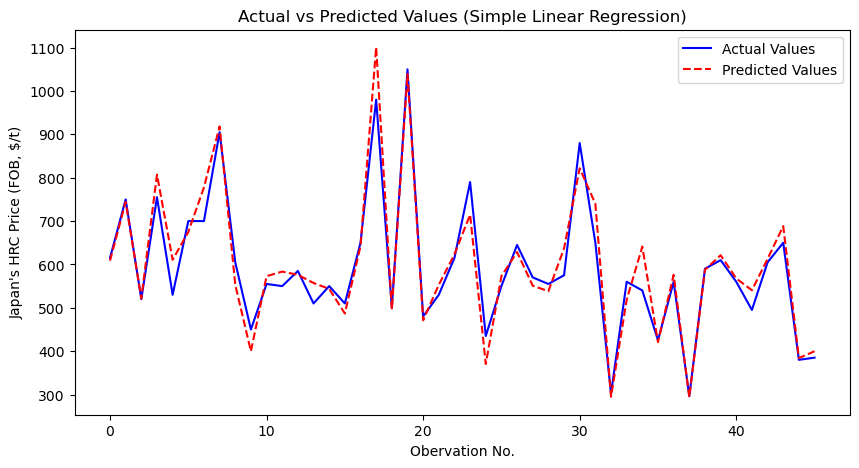

In [138]:
# Plot actual vs predicted Japan HRC Prices
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test)), y_test, label="Actual Values", color="blue")
plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted Values", color="red", linestyle="dashed")

plt.xlabel("Obervation No.")
plt.ylabel("Japan's HRC Price (FOB, $/t)")
plt.title("Actual vs Predicted Values (Simple Linear Regression)")
plt.legend()
plt.show()

## Prediction of Japan HRC Prices using China's Prices - Polynomial Regression


In [ ]:
# Polynomial regression using second degree polynomial
poly = PolynomialFeatures(degree=2, include_bias=False)
poly

PolynomialFeatures(include_bias=False)

In [140]:
# Transform BOTH training and testing data
X_train_poly = poly.fit_transform(X_train)  # Fit and transform for training
X_test_poly = poly.transform(X_test)        # Only transform for testing

# Train the model using transformed training data
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Predict using the transformed test data
y_pred_poly = model.predict(X_test_poly)

In [141]:
# Get feature names and coefficients
feature_names_poly = ["Intercept"] + list(poly.get_feature_names_out(input_features=X.columns))
intercept_poly = model.intercept_
coef_poly = model.coef_

coefficients_poly = [intercept_poly] + list(coef_poly)

# Display results
pd.DataFrame({"Feature": feature_names_poly, "Coefficient": coefficients_poly})

,Feature,Coefficient
0,Intercept,-21.265600
1,"China HRC (FOB, $/t)",1.192575
2,"China HRC (FOB, $/t)^2",-0.000114


In [142]:
# Error metrics
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

print('Mean Absolute Error: ', mae_poly)
print('Mean Squared Error: ', mse_poly)
print('Root Mean Squared Error: ', rmse_poly)
print('R-squared: ', r2_poly)

Mean Absolute Error:  31.64571987704407
Mean Squared Error:  1843.6559315433028
Root Mean Squared Error:  42.93781470386334
R-squared:  0.9209961394524016


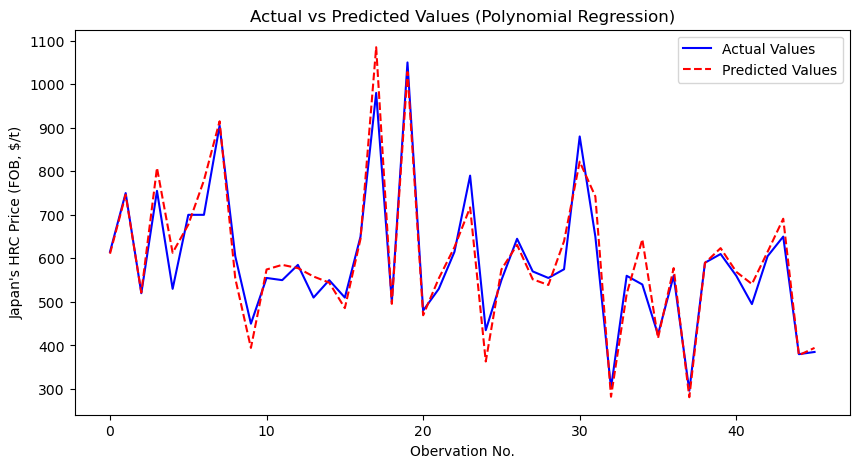

In [143]:
# Assuming y_test and y_pred are 1D arrays
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(y_test)), y_test, label="Actual Values", color="blue")
plt.plot(np.arange(len(y_pred_poly)), y_pred_poly, label="Predicted Values", color="red", linestyle="dashed")

plt.xlabel("Obervation No.")
plt.ylabel("Japan's HRC Price (FOB, $/t)")
plt.title("Actual vs Predicted Values (Polynomial Regression)")
plt.legend()
plt.show()

## Compare results from Linear Regression and Polynomial Regression (Degree=2)

In [ ]:
comparison_stats = {
    'Metric': ['Equation', 'Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'R-squared'],
    'Linear Regression': [f"JP Price = {coef_linear_reg[0]}*CN Price + {intercept_linear_reg}", mae, mse, rmse, r2],
    'Polynomial Regression with Degree=2': [f"JP Price = {coef_poly[1]}*(CN Price)^2 + {coef_poly[0]}*CN Price {intercept_poly}", mae_poly, mse_poly, rmse_poly, r2_poly]
}

pd.set_option('display.max_colwidth', None) # to prevent truncation of output
pd.DataFrame(comparison_stats)

,Metric,Linear Regression,Polynomial Regression with Degree=2
0,Equation,JP Price = 1.0497461121938285*CN Price + 20.80650829721958,JP Price = -0.00011421654157866243*(CN Price)^2 + 1.1925750780760398*CN Price -21.265600262335397
1,Mean Absolute Error,30.768591,31.64572
2,Mean Squared Error,1829.617813,1843.655932
3,Root Mean Squared Error,42.774032,42.937815
4,R-squared,0.921598,0.920996
